# **Predicting Election Results with Polling and Spending Data**

Fall 2024 Data Science Project

Paul Crumrine, Jamin Day, Garrison Wells, Jared Ramirez, Daniel Luom, and Xiwei(Aaron) Tong 

Contributions: 
- Paul Crumrine - 
- Jamin Day - 
- Garrison Wells - 
- Jared Ramirez - 
- Daniel Luom - 
- Xiwei(Aaron) Tong - 

<!-- A: Project idea
B: Dataset Curation and Preprocessing
C: Data Exploration and Summary Statistics
D: ML Algorithm Design/Development
E: ML Algorithm Training and Test Data Analysis
F: Visualization, Result Analysis, Conclusion
G: Final Tutorial Report Creation
H: Additional (not listed above) -->

## Introduction

For our topic we focused on US presidential elections and campaign spending. We know candidates focus on different states differently and money is massively influential, especially in American politics. So how can campaign spending, along with other predictors like polling and location, impact election results? What patterns exist in these factors and can they be used to make predictions or insights about US presidential elections? 

It goes without saying that the presidential election is important and is something a lot of people care about, or else it wouldn’t be plastered over regular and social media. A model that can completely predict an election based on spending and polling data would be impressive but is a bit of a pipe dream. Even if the model doesn't predict each state perfectly, this project should still be able to show where some correlation is and patterns that exist, even if it can’t predict with perfect accuracy. This would still be useful to measure the impact of campaign finance and gain new understanding of elections. 


**Imports**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
from scipy.stats import wilcoxon
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

# SECTION 3: Dataset Curation and Preprocessing

# Polling Data Preprocessing

Set the constants needed to process the data.

Date of each election being processed.

Party Affiliation of Candidates

In [2]:
election_days = {
    2024: datetime.date(2024, 11, 5),
    2020: datetime.date(2020, 11, 3),
    2016: datetime.date(2016, 11, 8),
    2012: datetime.date(2012, 11, 6),
    2008: datetime.date(2008, 11, 4),
    2004: datetime.date(2004, 11, 2)
}

candidate_parties = {
    'Donald Trump': 'Republican', 
    'Hillary Rodham Clinton': 'Democrat', 
    'Barack Obama': 'Democrat', 
    'Mitt Romney': 'Republican', 
    'John McCain': 'Republican', 
    'George W. Bush': 'Republican', 
    'John Kerry': 'Democrat',
    'Harris': 'Democrat',
    'Trump': 'Republican',
    'Joseph R. Biden Jr.': 'Democrat'
}

fix_party = {'DEM': 'Democrat', 'REP': 'Republican'}

standard_states = {
    'Nebraska CD-1': 'NE-1',
    'Nebraska CD-2': 'NE-2',
    'Nebraska CD-3': 'NE-3',
    'Maine CD-1': 'ME-1',
    'Maine CD-2': 'ME-2'
}

**Load Datasets**

Load the data for past election results from

MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V8, UNF:6:F0opd1IRbeYI9QyVfzglUw== [fileUNF]

In [3]:
past_elections = pd.read_csv('1976-2020-president.csv')

**Data Exploration**

In [4]:
## No exploration so far

**Data Processing**

Extract the important columns.

Then, for each state in each cycle, assign the party which won that state, this will be used later to label the data.

In [5]:
past_elections = past_elections[['state', 'year', 'party_detailed', 'candidatevotes']]

winning_parties = (past_elections.loc[past_elections.groupby(['state', 'year'])['candidatevotes'].idxmax()][['state', 'year', 'party_detailed']])

Load the polling data for all the elections from the two csv files.

Convert the dates to datetime format for easier processing, and rename the columns so that they match between the dataframes.

In [6]:
polling_20to24 = pd.read_csv('presidential_general_averages.csv')

## Convert columns to useable datatypes
polling_20to24['date'] = pd.to_datetime(polling_20to24['date']).dt.date
polling_20to24['cycle'] = polling_20to24['cycle'].astype(int)

polling_else = pd.read_csv('pres_pollaverages_1968-2016.csv')

## Convert columns to useable datatypes
polling_else['modeldate'] = pd.to_datetime(polling_else['modeldate']).dt.date
polling_else['cycle'] = polling_else['cycle'].astype(int)

## Extract important columns from both dataframes
important_20to24 = polling_20to24[['state', 'cycle', 'candidate', 'date', 'pct_estimate']].copy()
important_else = polling_else[['state', 'cycle', 'candidate_name', 'modeldate', 'pct_estimate']][polling_else['cycle'] >= 2004]

## Rename columns so that they match
important_20to24.rename(columns={'candidate': 'party'}, inplace=True)
important_else.rename(columns={'candidate_name': 'party', 'modeldate': 'date'}, inplace=True)

## Convert candidate names to their corresponding party
important_20to24['party'] = important_20to24['party'].map(lambda e: candidate_parties[e] if e in candidate_parties.keys() else e)
important_else['party'] = important_else['party'].map(lambda e: candidate_parties[e] if e in candidate_parties.keys() else e)

## Fill in missing values
important_20to24['pct_estimate'] = important_20to24['pct_estimate'].fillna(polling_20to24['pct_trend_adjusted'])

## Combine all cycles into one dataframe
combined_df = pd.concat([important_20to24, important_else], ignore_index=True)
combined_df.reset_index(inplace=True)
combined_df = combined_df[combined_df['state'] != 'National']

## Fix some inconsistent naming of the congressional districts for Nebraska and Maine
combined_df['state'] = combined_df['state'].map(lambda e: 'NE-2' if e == 'Nebraska Cd 2' else e)
combined_df['state'] = combined_df['state'].map(lambda e: 'ME-2' if e == 'Maine Cd 2' else e)

From our data exploration, we know that the 2024 data is missing for quite a few states, so we need to add those states using the raw polling data.
1. Load the raw polling data

In [7]:
poll_data = pd.read_csv('president_polls.csv')

Grab the most important columns

In [8]:
processed_polls = poll_data[['pollster_id', 'state', 'end_date', 'party', 'pct', 'office_type']]

## Ignore the rows with NaN states bc those are national polls
processed_polls = processed_polls[processed_polls['state'].notna()].reset_index()

## Convert the dates to datetime
processed_polls['end_date'] = pd.to_datetime(processed_polls['end_date'], format="mixed", dayfirst=False).dt.date

2. Get the pollsters with grades higher than 2.3. This ensures that the polling average is not skewed by biased pollsters.

In [9]:
top_pollsters = poll_data.groupby('pollster_id', as_index=False).agg({'numeric_grade': 'max'})
top_pollsters.sort_values(by='numeric_grade', ascending=False, inplace=True)
top_pollsters = top_pollsters[top_pollsters['numeric_grade'] > 1.6]['pollster_id'].to_list()

Remove all entries that aren't by the top pollsters. And fix the state names for the Nebraska and Maine districts

In [10]:
processed_polls = processed_polls[processed_polls['pollster_id'].isin(top_pollsters)]
processed_polls['party'] = processed_polls['party'].map(lambda e: fix_party[e] if e in fix_party.keys() else e)
processed_polls['state'] = processed_polls['state'].map(lambda e: standard_states[e] if e in standard_states.keys() else e)

3. Add the necessary columns to the polls to match the combined_df, and also reorder them too

In [11]:
processed_polls['cycle'] = 2024
processed_polls = processed_polls[['state', 'cycle', 'party', 'end_date', 'pct']].copy()

4. Concat the new data onto the combined data

In [12]:
processed_polls.rename(columns={'pct': 'pct_estimate', 'end_date': 'date'}, inplace=True)
combined_df = pd.concat([combined_df, processed_polls], ignore_index=True)

Some states don't have polls within the month of the 2024 election because of how recent it was, so we will instead use the most recent poll for those states.

In [13]:
most_recent = processed_polls.groupby('state')['date'].max().reset_index()
most_recent = most_recent[most_recent['date'] < (election_days[2024] + relativedelta(months=-1))].to_dict()

temp = {}
for k in most_recent['state'].keys():
    temp[most_recent['state'][k]] = most_recent['date'][k]

most_recent = temp
most_recent
processed_polls.groupby('state').count()

,cycle,party,date,pct_estimate
state,,,,
Alabama,6,6,6,6
Alaska,33,33,33,33
Arizona,631,631,631,631
Arkansas,10,10,10,10
California,130,130,130,130
Colorado,33,33,33,33
Connecticut,13,13,13,13
Delaware,4,4,4,4
Florida,241,241,241,241


For each of the elections being processed, get the one month average for each major party, 



In [14]:
processed_data = None

for year in election_days.keys():
    ## Set the dates needed, election day, one and two months before
    election_date = election_days[year]
    one_month_before = election_date + relativedelta(months=-1)
    two_month_before = election_date + relativedelta(months=-2)
    
    ## Filter combined dataframe with the dates
    one_month_filtered = combined_df[(combined_df['date'] >= one_month_before) & (combined_df['date'] <= election_date) & (combined_df['party'].isin(['Democrat', 'Republican']))].reset_index(drop=True)

    print(one_month_filtered[one_month_filtered['state'] == 'Alabama'])
    
    two_month_filtered = combined_df[(combined_df['date'] >= two_month_before) & (combined_df['date'] <= one_month_before) & (combined_df['party'].isin(['Democrat', 'Republican']))]

    if year == 2024:
        for st in most_recent.keys():
            date = most_recent[st]

            recent = combined_df[(combined_df['date'] >= date + relativedelta(months=-1)) & (combined_df['date'] <= date) & (combined_df['party'].isin(['Democrat', 'Republican'])) & (combined_df['state'] == st)]

            one_month_filtered = pd.concat([one_month_filtered, recent], ignore_index=True).reset_index(drop=True)
        
        two_month_filtered = two_month_filtered[~two_month_filtered['state'].isin(most_recent.keys())]

    ## Group by state then party, then get average over month
    grouped_one_month = one_month_filtered.groupby(['state', 'party'])['pct_estimate'].mean().reset_index()

    grouped_two_month = two_month_filtered.groupby(['state', 'party'])['pct_estimate'].mean().reset_index()

    ## Pivot dataframe so that the Democrat and Republican polling averages are on the same rows
    temp = grouped_two_month.pivot(index='state', columns='party', values='pct_estimate').reset_index()

    ## Reorder and rename columns
    temp = temp[['state', 'Republican', 'Democrat']]
    temp.columns = ['state', 'polling_avg_republican2', 'polling_avg_democrat2']

    temp['cycle'] = year

    ## Create a key to merge the one month and two month dataframes on
    temp['jkey'] = temp['state'] + temp['cycle'].astype(str)

    ## Repeat above for the one month dataframe
    result = grouped_one_month.pivot(index='state', columns='party', values='pct_estimate').reset_index()

    result = result[['state', 'Republican', 'Democrat']]

    result.columns = ['state', 'polling_avg_republican', 'polling_avg_democrat']

    result['cycle'] = year
    result['jkey'] = result['state'] + result['cycle'].astype(str)

    ## Merge the two dataframes
    result = pd.merge(result, temp[['polling_avg_republican2', 'polling_avg_democrat2', 'jkey']], on='jkey', how='outer')

    ## Convert the 2 month polling average columns into polling change columns
    result['polling_avg_republican2'] -= result['polling_avg_republican']
    result['polling_avg_democrat2'] -= result['polling_avg_democrat']

    result.columns = ['state', 'polling_avg_republican', 'polling_avg_democrat', 'cycle', 'jkey', 'month_change_republican', 'month_change_democrat']

    # result.drop(['jkey', 'cycle'], axis=1, inplace=True)

    ## Add the new dataframe onto the accumulator
    if processed_data is None:
        processed_data = result
    else:
        processed_data = pd.concat([processed_data, result], ignore_index=True).reset_index(drop=True)

processed_data.fillna(0, inplace=True)
processed_data.count()

Empty DataFrame
Columns: [index, state, cycle, party, date, pct_estimate]
Index: []
    index    state  cycle       party        date  pct_estimate
0     0.0  Alabama   2020    Democrat  2020-11-03      37.82732
1     1.0  Alabama   2020  Republican  2020-11-03      57.36126
2     2.0  Alabama   2020    Democrat  2020-11-02      37.82732
3     3.0  Alabama   2020  Republican  2020-11-02      57.36126
4     4.0  Alabama   2020    Democrat  2020-11-01      38.07011
..    ...      ...    ...         ...         ...           ...
59   59.0  Alabama   2020  Republican  2020-10-05      56.89531
60   60.0  Alabama   2020    Democrat  2020-10-04      38.79457
61   61.0  Alabama   2020  Republican  2020-10-04      56.16731
62   62.0  Alabama   2020    Democrat  2020-10-03      38.74995
63   63.0  Alabama   2020  Republican  2020-10-03      56.24868

[64 rows x 6 columns]
        index    state  cycle       party        date  pct_estimate
0     52757.0  Alabama   2016  Republican  2016-10-08    

state                      316
polling_avg_republican     316
polling_avg_democrat       316
cycle                      316
jkey                       316
month_change_republican    316
month_change_democrat      316
dtype: int64

**Labeling Data**

Now that we have the processed data, all that is left is for us to label the data since we will be using supervised learning.

The data labeling will consist of a new column which will contain either Democrat or Republican, marking which party won that state in the given cycle.

1. First, add the merging key to the winning_parties dataframe to prepare for merging with the processed data

In [15]:
winning_parties['jkey'] = winning_parties['state'].map(lambda e: e.lower()) + winning_parties['year'].astype(str)

2. Ensure that the merging key will match properly, so convert all to lower case.

In [16]:
processed_data['jkey'] = processed_data['jkey'].map(lambda e: e.lower())

3. Merge the two dataframes so that the data is all labeled, except for the 2024 data, which will need to be filled in manually.

**Make sure to check for NaN values, especially due to the Maine and Nebraska splitting their electoral votes.**

In [17]:
# result = pd.merge(result, temp[['polling_avg_republican2', 'polling_avg_democrat2', 'jkey']], on='jkey', how='outer')
processed_data = pd.merge(processed_data, winning_parties[['party_detailed', 'jkey']], on='jkey', how='left')

In [18]:
processed_data.rename(columns={'party_detailed': 'winning_party'}, inplace=True)
processed_data.count()

state                      316
polling_avg_republican     316
polling_avg_democrat       316
cycle                      316
jkey                       316
month_change_republican    316
month_change_democrat      316
winning_party              248
dtype: int64

In [19]:
processed_data[processed_data['cycle'] == 2024].count()

state                      55
polling_avg_republican     55
polling_avg_democrat       55
cycle                      55
jkey                       55
month_change_republican    55
month_change_democrat      55
winning_party               0
dtype: int64

There it is, there are 52 entries from the 2024 cycle which are expected to not have labels, yet 65 rows are missing a winning_party label.

4. We need to fix some of that missing data, unfortunately this will need to be done manually.

Get the merge keys for the missing values that are not from 2024. Any 2024 cycle row is expected to not have a label because the official results are not out yet and thus aren't in any dataset.

In [20]:
missing_jkeys = processed_data[(processed_data['winning_party'].isna()) & (processed_data['cycle'] != 2024)]['jkey'].to_list()
missing_jkeys

['me-12020',
 'me-22020',
 'ne-22020',
 'me-12016',
 'me-22016',
 'ne-12016',
 'ne-22016',
 'ne-32016',
 'me-12012',
 'me-22012',
 'ne-12012',
 'ne-22012',
 'ne-32012']

In [21]:
processed_data[(processed_data['winning_party'].isna()) & (processed_data['cycle'] != 2024)][['state', 'cycle']]

,state,cycle
74,ME-1,2020
75,ME-2,2020
84,NE-2,2020
128,ME-1,2016
129,ME-2,2016
138,NE-1,2016
139,NE-2,2016
140,NE-3,2016
182,ME-1,2012
183,ME-2,2012


Create a dataframe with the missing data, using the jkey.

In [22]:
missing_data = {
    'jkey': missing_jkeys,
    'winning_party': [
        'Democrat',
        'Republican',
        'Democrat',
        'Democrat',
        'Republican',
        'Republican',
        'Republican',
        'Republican',
        'Democrat',
        'Democrat',
        'Republican',
        'Republican',
        'Republican'
    ]
}

Now merge it with the dataset

In [23]:
for key in missing_data['jkey']:
    processed_data.loc[processed_data['jkey'] == key, 'winning_party'] = missing_data['winning_party'][missing_data['jkey'].index(key)]

Check that it worked. It did, only 52 entries are missing labels. This is expected.

In [24]:
processed_data.count()

state                      316
polling_avg_republican     316
polling_avg_democrat       316
cycle                      316
jkey                       316
month_change_republican    316
month_change_democrat      316
winning_party              261
dtype: int64

**Final Fixups**

Time to add the labels for 2024, unfortunately this must be done manually since the 2024 results aren't available in any dataset yet.

In [25]:
election_results = {
    "Alabama": "Republican",
    "Alaska": "Republican",
    "Arizona": "Republican",
    "Arkansas": "Republican",
    "California": "Democrat",
    "Colorado": "Democrat",
    "Connecticut": "Democrat",
    "Delaware": "Democrat",
    "Florida": "Republican",
    "Georgia": "Republican",
    "Hawaii": "Democrat",
    "Idaho": "Republican",
    "Illinois": "Democrat",
    "Indiana": "Republican",
    "Iowa": "Republican",
    "Kansas": "Republican",
    "Kentucky": "Republican",
    "Louisiana": "Republican",
    "Maine": "Democrat",
    "ME-1": "Democrat", 
    "ME-2": "Republican",
    "Maryland": "Democrat",
    "Massachusetts": "Democrat",
    "Michigan": "Republican",
    "Minnesota": "Democrat",
    "Mississippi": "Republican",
    "Missouri": "Republican",
    "Montana": "Republican",
    "Nebraska": "Republican", 
    "NE-1": "Republican", 
    "NE-2": "Democrat", 
    "NE-3": "Republican",
    "Nevada": "Republican",
    "New Hampshire": "Democrat",
    "New Jersey": "Democrat",
    "New Mexico": "Democrat",
    "New York": "Democrat",
    "North Carolina": "Republican",
    "North Dakota": "Republican",
    "Ohio": "Republican",
    "Oklahoma": "Republican",
    "Oregon": "Democrat",
    "Pennsylvania": "Republican",
    "Rhode Island": "Democrat",
    "South Carolina": "Republican",
    "South Dakota": "Republican",
    "Tennessee": "Republican",
    "Texas": "Republican",
    "Utah": "Republican",
    "Vermont": "Democrat",
    "Virginia": "Democrat",
    "Washington": "Democrat",
    "West Virginia": "Republican",
    "Wisconsin": "Republican",
    "Wyoming": "Republican",
    "District of Columbia": "Democrat"
}

In [26]:
for v in sorted(election_results.keys()):
    if v not in list(processed_data[processed_data['cycle'] == 2024]['state'].unique()):
        print(v)

District of Columbia


Apply those results to the combined dataframe

In [27]:
for key in election_results.keys():
    if key != "District of Columbia":
        processed_data.loc[(processed_data['state'] == key) & (processed_data['cycle'] == 2024), 'winning_party'] = election_results[key]
## Minnesota has a special name for the Democratic Party, need to fix it
processed_data['winning_party'] = processed_data['winning_party'].map(lambda e : 'Democrat' if e == 'DEMOCRATIC-FARMER-LABOR' else e)

## Case is not consistent with this column
processed_data['winning_party'] = processed_data['winning_party'].map(lambda e: e.upper())

Give it one final check with count

In [28]:
processed_data.count()

state                      316
polling_avg_republican     316
polling_avg_democrat       316
cycle                      316
jkey                       316
month_change_republican    316
month_change_democrat      316
winning_party              316
dtype: int64

**And nothing is missing, meaning, that we are done with processing the polling data.**

# **Spending data Preprocessing**

In this section I will process the data from the FEC to get the total amount spent by each presidential candidate in each state for the 2008, 2012, 2016, 2020, and 2024 elctions. 

Raw data is from here: https://www.fec.gov/data/candidates/president/presidential-map/ 
To get the data yourself, use the dropdown menu to select the electin year, open the tab on the side of the map for spending, and click "Export spending data". 
The files do not have labeled names so you need to label them accordingly, we have followed the pattern "spending_data_{year}.csv". 

Import spending data of presidential candidates for the 2008, 2012, 2016, 2020, and 2024 elctions. 

In [29]:
years = ['2008', '2012', '2016', '2020', '2024']
spending_dfs = dict()
state_sums = dict()
for year in years:
    spending_dfs[year] = pd.read_csv(f"spending_data_{year}.csv", index_col=False, low_memory=False)
    # state_sums[year] = spending_dfs[year].groupby('recipient_st').sum('disb_amt').sort_values('disb_amt')

# spending_24_df = pd.read_csv("spending_data_2024.csv", index_col=False, low_memory=False)
# spending_24_df.groupby('recipient_st').sum('disb_amt').sort_values('disb_amt')
# spending_24_df.head()
# spending_dfs
# state_sums['2024']

Upon inspection some states have been labeled wrong. For example some rows have C, since they occur in san francisco we can assume this should be CA. 

For each year I have a comment labeling which abbreviations need to be replaced, for example in 2008 'AA' needs to be replaced by 'MA'. 

Most were done with a simple dictionary replace, but in 2024 some bad labels were for different states, for example zip codes in Iowa and Indiana were both labled 'I', so these require extra attention to replace them by zip code. 

Then once all errors are corrected we remove all rows where the recipient state is not one of the 50 US states or DC, for example some transactions are labled as "UK" which isn't useful for our analysis. 

In [30]:
# correct 2008 states 
spending_dfs['2008']['recipient_st']= spending_dfs['2008']['recipient_st'].replace({'AA': 'MA', 'C': 'CA', 'I': 'IA', 'II': 'IL', 'K': 'KS', 'KA': 'KS' , 'N': 'NC', 'VW': 'WV', '46': 'IN', 'MY': 'MT', 'OA': 'PA', 'T': 'TX', 'WW': 'WA'})

# AA = MA
# C = CA
# I = IA
# II = IL
# K = KS
# KA = KS 
# N = NC
# VW = WV
# 46 = IN
# MY = MT
# OA = PA
# T = TX
# WW = WA


# correct 2012 states 
spending_dfs['2012']['recipient_st']= spending_dfs['2012']['recipient_st'].replace({'D.': 'DC', 'MY': 'NY', 'HA': 'HI', 'MH': 'NH', 'HN': 'NH'})

# "D." = "DC"
# MY = NY
# HA = HI
# MH = NH
# HN = HN

# correct 2016 states 
spending_dfs['2016']['recipient_st']= spending_dfs['2016']['recipient_st'].replace({'D.': 'DC', 'MY': 'NY', 'HA': 'HI', 'MH': 'NH', 'HN': 'NH'})

# NB = NE
# D. = DC


# correct 2020 states 
# none


# correct 2024 states 
spending_dfs['2024']['recipient_st']= spending_dfs['2024']['recipient_st'].replace({'C': 'CA', 'AA': 'CA', 'F': 'FL', 'G': 'GA', 'T': 'TX'})
spending_dfs['2024'].loc[spending_dfs['2024']['recipient_zip'] == '46038', 'recipient_st'] = 'IN'
spending_dfs['2024']['recipient_st'] = spending_dfs['2024']['recipient_st'].replace('I', 'IA')
spending_dfs['2024'].loc[spending_dfs['2024']['recipient_zip'] == '03276', 'recipient_st'] = 'NH'
spending_dfs['2024'].loc[spending_dfs['2024']['recipient_zip'] == '03063', 'recipient_st'] = 'NH'
spending_dfs['2024']['recipient_st'] = spending_dfs['2024']['recipient_st'].replace('N', 'NY')
spending_dfs['2024'].loc[spending_dfs['2024']['recipient_zip'] == '19802', 'recipient_st'] = 'NJ'

# C = CA,
# AA = CA
# F = FL
# G = GA
# T = TX
# I = IN or IA
# N = NH or NY


states = [
        'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 
        'IL', 'IN', 'LA', 'MA', 'MD', 'ME', 'MN', 'MO', 'NC', 'NE', 
        'NH', 'NJ', 'NY', 'OK', 'PA', 'SC', 'TN', 'TX', 'VA', 'SD',
        'WA', 'WI', 'WY', 'OH', 'WV', 'AK', 'DE', 'HI', 'ID', 'KS', 
        'KY', 'MI', 'MS', 'MT', 'ND', 'NM', 'NV', 'OR', 'RI', 'UT', 
        'VT'
        ]

# remove transactions not in the 50 states or DC
for year in spending_dfs:
    spending_dfs[year] = spending_dfs[year][spending_dfs[year]['recipient_st'].isin(states)]


Next we want to remove the candidates that aren't either the Democratic or Republican nominee, while other candidates exist they don't receive a significant amount of votes. This will leave us with a dataframe per candidate per election year, so 10 in total. 

In [31]:
party_spending_dfs = {}

# 2008
# Republican: 'McCain, John S'
# Dem : 'Obama, Barack'
# spending_dfs['2008'] = spending_dfs['2024'][spending_dfs['2024']['cand_nm'].isin(['McCain, John S', 'Obama, Barack'])]
party_spending_dfs['2008_R'] = spending_dfs['2008'][spending_dfs['2008']['cand_nm'] == 'McCain, John S']
party_spending_dfs['2008_D'] = spending_dfs['2008'][spending_dfs['2008']['cand_nm'] == 'Obama, Barack']

# 2012
# Rep: 'Romney, Mitt'
# Dem: 'Obama, Barack'
# spending_dfs['2012'] = spending_dfs['2024'][spending_dfs['2024']['cand_nm'].isin(['Romney, Mitt', 'Obama, Barack'])]
party_spending_dfs['2012_R'] = spending_dfs['2012'][spending_dfs['2012']['cand_nm'] == 'Romney, Mitt']
party_spending_dfs['2012_D'] = spending_dfs['2012'][spending_dfs['2012']['cand_nm'] == 'Obama, Barack']

# 2016
# Rep: 'Trump, Donald J.'
# Dem: 'Clinton, Hillary Rodham'
# spending_dfs['2016'] = spending_dfs['2024'][spending_dfs['2024']['cand_nm'].isin(['Trump, Donald J.', 'Clinton, Hillary Rodham'])]
party_spending_dfs['2016_R'] = spending_dfs['2016'][spending_dfs['2016']['cand_nm'] == 'Trump, Donald J.']
party_spending_dfs['2016_D'] = spending_dfs['2016'][spending_dfs['2016']['cand_nm'] == 'Clinton, Hillary Rodham']

# 2020
# Rep: 'Trump, Donald J.'
# Dem: 'Biden, Joseph R Jr'
# spending_dfs['2020'] = spending_dfs['2024'][spending_dfs['2024']['cand_nm'].isin(['Trump, Donald J.', 'Biden, Joseph R Jr'])]
party_spending_dfs['2020_R'] = spending_dfs['2020'][spending_dfs['2020']['cand_nm'] == 'Trump, Donald J.']
party_spending_dfs['2020_D'] = spending_dfs['2020'][spending_dfs['2020']['cand_nm'] == 'Biden, Joseph R Jr']

# 2024
# Rep: 'Trump, Donald J.'
# Dem: 'Harris, Kamala' 
# spending_dfs['2024'] = spending_dfs['2024'][spending_dfs['2024']['cand_nm'].isin(['Trump, Donald J.', 'Harris, Kamala'])]
party_spending_dfs['2024_R'] = spending_dfs['2024'][spending_dfs['2024']['cand_nm'] == 'Trump, Donald J.']
party_spending_dfs['2024_D'] = spending_dfs['2024'][spending_dfs['2024']['cand_nm'] == 'Harris, Kamala']


Nebraska and Maine split their electoral votes, 1 vote goes to the popular winner in each congressional district while 2 votes go to the popular winner of the whole state. So we will duplicate spending in Nebraska and Maine to count towards the overall state and the district it happened in, since later these will be predicted seperatley. 

In [32]:
# for year, df in party_spending_dfs.items():
#     print(year, df[df['recipient_st'].isin(['NE', 'ME'])]['recipient_city'].unique())

year = '2008'
print(f'{year}_R', party_spending_dfs[f'{year}_R'][party_spending_dfs[f'{year}_R']['recipient_st'] == 'NE']['recipient_city'].unique())
print(f'{year}_D', party_spending_dfs[f'{year}_D'][party_spending_dfs[f'{year}_D']['recipient_st'] == 'NE']['recipient_city'].unique())

print(f'{year}_R', party_spending_dfs[f'{year}_R'][party_spending_dfs[f'{year}_R']['recipient_st'] == 'ME']['recipient_city'].unique())
print(f'{year}_D', party_spending_dfs[f'{year}_D'][party_spending_dfs[f'{year}_D']['recipient_st'] == 'ME']['recipient_city'].unique())


2008_R ['OMAHA' 'NORFOLK' 'SOUTH SIOUX CITY']
2008_D ['ELM CREEK' 'OMAHA' 'YORK' 'NORTH PLATTE' '800-2289872' 'S. SIOUX CITY'
 'LINCOLN' 'SEWARD' 'KIMBALL' 'GRAND ISLAND' 'WACO' 'AURORA' 'KEARNEY'
 'SUTHERLAND' 'N. PLATTE' 'OGALLALA' 'NEW YORK' 'SIDNEY' 'NORFOLK'
 'LEXINGTON' 'COZAD' 'GERING' 'SOUTH SIOUX CITY' 'WINNEBAGO' 'LA VISTA'
 'MCCOOK' 'SUITE 270']
2008_R ['GRAY' 'S PORTLAND' 'AUGUSTA' 'SOUTH PORTLAND' 'PORTLAND' 'SCARBOROUGH'
 'KENNEBUNKPORT' 'BREWER' 'BANGOR' 'PRESQUE ISLE' 'ORONO' 'AUBURN'
 'PALMYRA' 'CORRINA']
2008_D ['SCARBOROUGH' 'CAPE ELIZABETH' 'BIDDEFORD' 'PORTLAND' 'BRUNSWICK'
 'CHINA VILLAGE' 'KITTERY' 'WINTHROP' 'BELFAST' 'ORONO' 'LEWISTON'
 'CAPE NEDDICK' 'WATERVILLE' 'AUGUSTA' 'BANGOR' 'SACO' 'SOUTH PORTLAND'
 'KENNEBUNK' 'WOOLWICH' 'CAMDEN' 'HAMPTDEN' 'LINCOLN' 'PRESQUE ISLE']


In [33]:
# 2008 
NE_1_2008 = ['NORFOLK', 'SOUTH SIOUX CITY', 'S. SIOUX CITY', 'SEWARD', 'NORFOLK', 'WINNEBAGO', 'LINCOLN']
NE_2_2008 = ['OMAHA', '800-2289872', 'NEW YORK', 'LA VISTA', 'SUITE 270']
NE_3_2008 = ['ELM CREEK', 'YORK', 'NORTH PLATTE', 'KIMBALL', 'GRAND ISLAND', 'WACO', 'AURORA','KEARNEY', 
             'SUTHERLAND', 'N. PLATTE', 'OGALLALA', 'SIDNEY', 'LEXINGTON', 'COZAD', 'GERING', 'MCCOOK']

ME_1_2008 = ['GRAY', 'S PORTLAND', 'AUGUSTA', 'SOUTH PORTLAND', 'PORTLAND', 'SCARBOROUGH', 'KENNEBUNKPORT', 
             'CAPE ELIZABETH', 'BIDDEFORD', 'BRUNSWICK', 'CHINA VILLAGE', 'KITTERY', 'WINTHROP', 'LEWISTON', 
             'CAPE NEDDICK', 'SACO', 'KENNEBUNK', 'WOOLWICH', 'CAMDEN']
ME_2_2008 = ['BREWER', 'BANGOR', 'PRESQUE ISLE', 'ORONO', 'AUBURN', 'PALMYRA', 'CORRINA', 'BELFAST',
             'WATERVILLE', 'HAMPTDEN']

# 2012
# Nebraksa used the same districts from 2003-2013
NE_1_2012 = ['SOUTH SIOUX CITY', 'LINCOLN']
NE_2_2012 = ['OMAHA', 'LAVISTA', 'BELLEVUE']
NE_3_2012 = ['GRAND ISLAND']

# Maine used the same districts from 2003-2013
ME_1_2012 = ['S. PORTLAND', 'AUGUSTA', 'SOUTH PORTLAND', 'PORTLAND', 'SCARBOROUGH', 'LEWISTON', 
             'KENNEBUNK', 'FREEPORT', 'WESTBROOK', 'FARMINGDALE', 'WATERVILLE', 'RICHMOND']
ME_2_2012 = ['BREWER', 'BETHEL', 'OXFORD', 'MACHIAS', 'HAMPDEN']

# 2016 
NE_1_2016 = [' LINCOLN', 'LINCOLN']
NE_2_2016 = ['OMAHA']
NE_3_2016 = ['SOUTH SIOUX CITY', 'HASTINGS']

ME_1_2016 = ['BIDDEFORD', 'RICHMOND', 'SCARBOROUGH', 'PORTLAND', 'SOUTH PORTLAND', 'AUGUSTA', 'SACO',
             'BATH', 'ROCKPORT', 'FALMOUTH', 'WELLS', 'LISBON', 'ROCKLAND']
ME_2_2016 = ['BANGOR', 'BELFAST', 'LEWISTON', 'ELLSWORTH']

# 2020 
NE_1_2020 = []
NE_2_2020 = ['OMAHA', 'PAPILLION']
NE_3_2020 = ['KEARNEY']

ME_1_2020 = ['AUGUSTA', 'PORTLAND', 'SACO', 'SCARBOROUGH', 'OLD ORCHARD BEACH', 'CAMDEN', 'BATH']
ME_2_2020 = ['LEWSITON', 'LEWISTON', 'BANGOR', 'PALMYRA', 'HERMON', 'ORRINGTON', 'NORTH ANSON', 'MACHIAS', 
             'HOLDEN', 'SOUTH PARIS', 'BAR HARBOR', 'ELLSWORTH', 'PRESQUE ISLE', 'SOUTHWEST HARBOR',
             'ELLSWORTH', 'STONINGTON', 'BREWER', 'FORT FAIRFIELD']

# 2024
NE_1_2024 = []
NE_2_2024 = ['OMAHA', 'BOYS TOWN']
NE_3_2024 = ['HASTINGS']

ME_1_2024 = ['SCARBOROUGH', 'LEBANON', 'PORTLAND', 'YORK BEACH']
ME_2_2024 = ['BANGOR']



Now that locations are separated by district we can add the new values

In [34]:
# R_2008
R_2008_NE_new = party_spending_dfs['2008_R'][party_spending_dfs['2008_R']['recipient_st'] == 'NE'].copy()
R_2008_NE_new.loc[R_2008_NE_new['recipient_city'].isin(NE_1_2008), 'recipient_st'] = 'NE-1'
R_2008_NE_new.loc[R_2008_NE_new['recipient_city'].isin(NE_2_2008), 'recipient_st'] = 'NE-2'
R_2008_NE_new.loc[R_2008_NE_new['recipient_city'].isin(NE_3_2008), 'recipient_st'] = 'NE-3'
# R_2008_NE_new = None 

R_2008_ME_new = party_spending_dfs['2008_R'][party_spending_dfs['2008_R']['recipient_st'] == 'ME'].copy()
R_2008_ME_new.loc[R_2008_ME_new['recipient_city'].isin(ME_1_2008), 'recipient_st'] = 'ME-1'
R_2008_ME_new.loc[R_2008_ME_new['recipient_city'].isin(ME_2_2008), 'recipient_st'] = 'ME-2'
# R_2008_ME_new = None

# D_2008
D_2008_NE_new = party_spending_dfs['2008_D'][party_spending_dfs['2008_D']['recipient_st'] == 'NE'].copy()
D_2008_NE_new.loc[D_2008_NE_new['recipient_city'].isin(NE_1_2008), 'recipient_st'] = 'NE-1'
D_2008_NE_new.loc[D_2008_NE_new['recipient_city'].isin(NE_2_2008), 'recipient_st'] = 'NE-2'
D_2008_NE_new.loc[D_2008_NE_new['recipient_city'].isin(NE_3_2008), 'recipient_st'] = 'NE-3'
# D_2008_NE_new = None

D_2008_ME_new = party_spending_dfs['2008_D'][party_spending_dfs['2008_D']['recipient_st'] == 'ME'].copy()
D_2008_ME_new.loc[D_2008_ME_new['recipient_city'].isin(ME_1_2008), 'recipient_st'] = 'ME-1'
D_2008_ME_new.loc[D_2008_ME_new['recipient_city'].isin(ME_2_2008), 'recipient_st'] = 'ME-2'
# D_2008_ME_new = None

# R_2012
R_2012_NE_new = party_spending_dfs['2012_R'][party_spending_dfs['2012_R']['recipient_st'] == 'NE'].copy()
R_2012_NE_new.loc[R_2012_NE_new['recipient_city'].isin(NE_1_2012), 'recipient_st'] = 'NE-1'
R_2012_NE_new.loc[R_2012_NE_new['recipient_city'].isin(NE_2_2012), 'recipient_st'] = 'NE-2'
R_2012_NE_new.loc[R_2012_NE_new['recipient_city'].isin(NE_3_2012), 'recipient_st'] = 'NE-3'
# R_2012_NE_new = None 

R_2012_ME_new = party_spending_dfs['2012_R'][party_spending_dfs['2012_R']['recipient_st'] == 'ME'].copy()
R_2012_ME_new.loc[R_2012_ME_new['recipient_city'].isin(ME_1_2012), 'recipient_st'] = 'ME-1'
R_2012_ME_new.loc[R_2012_ME_new['recipient_city'].isin(ME_2_2012), 'recipient_st'] = 'ME-2'
# R_2012_ME_new = None

# D_2012
D_2012_NE_new = party_spending_dfs['2012_D'][party_spending_dfs['2012_D']['recipient_st'] == 'NE'].copy()
D_2012_NE_new.loc[D_2012_NE_new['recipient_city'].isin(NE_1_2012), 'recipient_st'] = 'NE-1'
D_2012_NE_new.loc[D_2012_NE_new['recipient_city'].isin(NE_2_2012), 'recipient_st'] = 'NE-2'
D_2012_NE_new.loc[D_2012_NE_new['recipient_city'].isin(NE_3_2012), 'recipient_st'] = 'NE-3'
# D_2012_NE_new = None

D_2012_ME_new = party_spending_dfs['2012_D'][party_spending_dfs['2012_D']['recipient_st'] == 'ME'].copy()
D_2012_ME_new.loc[D_2012_ME_new['recipient_city'].isin(ME_1_2012), 'recipient_st'] = 'ME-1'
D_2012_ME_new.loc[D_2012_ME_new['recipient_city'].isin(ME_2_2012), 'recipient_st'] = 'ME-2'
# D_2012_ME_new = None

# R_2016
R_2016_NE_new = party_spending_dfs['2016_R'][party_spending_dfs['2016_R']['recipient_st'] == 'NE'].copy()
R_2016_NE_new.loc[R_2016_NE_new['recipient_city'].isin(NE_1_2016), 'recipient_st'] = 'NE-1'
R_2016_NE_new.loc[R_2016_NE_new['recipient_city'].isin(NE_2_2016), 'recipient_st'] = 'NE-2'
R_2016_NE_new.loc[R_2016_NE_new['recipient_city'].isin(NE_3_2016), 'recipient_st'] = 'NE-3'
# R_2016_NE_new = None 

R_2016_ME_new = party_spending_dfs['2016_R'][party_spending_dfs['2016_R']['recipient_st'] == 'ME'].copy()
R_2016_ME_new.loc[R_2016_ME_new['recipient_city'].isin(ME_1_2016), 'recipient_st'] = 'ME-1'
R_2016_ME_new.loc[R_2016_ME_new['recipient_city'].isin(ME_2_2016), 'recipient_st'] = 'ME-2'
# R_2016_ME_new = None

# D_2016
D_2016_NE_new = party_spending_dfs['2016_D'][party_spending_dfs['2016_D']['recipient_st'] == 'NE'].copy()
D_2016_NE_new.loc[D_2016_NE_new['recipient_city'].isin(NE_1_2016), 'recipient_st'] = 'NE-1'
D_2016_NE_new.loc[D_2016_NE_new['recipient_city'].isin(NE_2_2016), 'recipient_st'] = 'NE-2'
D_2016_NE_new.loc[D_2016_NE_new['recipient_city'].isin(NE_3_2016), 'recipient_st'] = 'NE-3'
# D_2016_NE_new = None

D_2016_ME_new = party_spending_dfs['2016_D'][party_spending_dfs['2016_D']['recipient_st'] == 'ME'].copy()
D_2016_ME_new.loc[D_2016_ME_new['recipient_city'].isin(ME_1_2016), 'recipient_st'] = 'ME-1'
D_2016_ME_new.loc[D_2016_ME_new['recipient_city'].isin(ME_2_2016), 'recipient_st'] = 'ME-2'
# D_2016_ME_new = None

# R_2020
R_2020_NE_new = party_spending_dfs['2020_R'][party_spending_dfs['2020_R']['recipient_st'] == 'NE'].copy()
R_2020_NE_new.loc[R_2020_NE_new['recipient_city'].isin(NE_1_2020), 'recipient_st'] = 'NE-1'
R_2020_NE_new.loc[R_2020_NE_new['recipient_city'].isin(NE_2_2020), 'recipient_st'] = 'NE-2'
R_2020_NE_new.loc[R_2020_NE_new['recipient_city'].isin(NE_3_2020), 'recipient_st'] = 'NE-3'
# R_2020_NE_new = None 

R_2020_ME_new = party_spending_dfs['2020_R'][party_spending_dfs['2020_R']['recipient_st'] == 'ME'].copy()
R_2020_ME_new.loc[R_2020_ME_new['recipient_city'].isin(ME_1_2020), 'recipient_st'] = 'ME-1'
R_2020_ME_new.loc[R_2020_ME_new['recipient_city'].isin(ME_2_2020), 'recipient_st'] = 'ME-2'
# R_2020_ME_new = None

# D_2020
D_2020_NE_new = party_spending_dfs['2020_D'][party_spending_dfs['2020_D']['recipient_st'] == 'NE'].copy()
D_2020_NE_new.loc[D_2020_NE_new['recipient_city'].isin(NE_1_2020), 'recipient_st'] = 'NE-1'
D_2020_NE_new.loc[D_2020_NE_new['recipient_city'].isin(NE_2_2020), 'recipient_st'] = 'NE-2'
D_2020_NE_new.loc[D_2020_NE_new['recipient_city'].isin(NE_3_2020), 'recipient_st'] = 'NE-3'
# D_2024_NE_new = None

D_2020_ME_new = party_spending_dfs['2020_D'][party_spending_dfs['2020_D']['recipient_st'] == 'ME'].copy()
D_2020_ME_new.loc[D_2020_ME_new['recipient_city'].isin(ME_1_2020), 'recipient_st'] = 'ME-1'
D_2020_ME_new.loc[D_2020_ME_new['recipient_city'].isin(ME_2_2020), 'recipient_st'] = 'ME-2'
# D_2024_ME_new = None


# R_2024
R_2024_NE_new = party_spending_dfs['2024_R'][party_spending_dfs['2024_R']['recipient_st'] == 'NE'].copy()
R_2024_NE_new.loc[R_2024_NE_new['recipient_city'].isin(NE_1_2024), 'recipient_st'] = 'NE-1'
R_2024_NE_new.loc[R_2024_NE_new['recipient_city'].isin(NE_2_2024), 'recipient_st'] = 'NE-2'
R_2024_NE_new.loc[R_2024_NE_new['recipient_city'].isin(NE_3_2024), 'recipient_st'] = 'NE-3'
# R_2024_NE_new = None 

R_2024_ME_new = party_spending_dfs['2024_R'][party_spending_dfs['2024_R']['recipient_st'] == 'ME'].copy()
R_2024_ME_new.loc[R_2024_ME_new['recipient_city'].isin(ME_1_2024), 'recipient_st'] = 'ME-1'
R_2024_ME_new.loc[R_2024_ME_new['recipient_city'].isin(ME_2_2024), 'recipient_st'] = 'ME-2'
# R_2024_ME_new = None

# D_2024
D_2024_NE_new = party_spending_dfs['2024_D'][party_spending_dfs['2024_D']['recipient_st'] == 'NE'].copy()
D_2024_NE_new.loc[D_2024_NE_new['recipient_city'].isin(NE_1_2024), 'recipient_st'] = 'NE-1'
D_2024_NE_new.loc[D_2024_NE_new['recipient_city'].isin(NE_2_2024), 'recipient_st'] = 'NE-2'
D_2024_NE_new.loc[D_2024_NE_new['recipient_city'].isin(NE_3_2024), 'recipient_st'] = 'NE-3'
# D_2024_NE_new = None

D_2024_ME_new = party_spending_dfs['2024_D'][party_spending_dfs['2024_D']['recipient_st'] == 'ME'].copy()
D_2024_ME_new.loc[D_2024_ME_new['recipient_city'].isin(ME_1_2024), 'recipient_st'] = 'ME-1'
D_2024_ME_new.loc[D_2024_ME_new['recipient_city'].isin(ME_2_2024), 'recipient_st'] = 'ME-2'
# D_2024_ME_new = None


In [35]:
party_spending_dfs['2008_R'] = pd.concat([party_spending_dfs['2008_R'], R_2008_NE_new, R_2008_ME_new])
party_spending_dfs['2012_R'] = pd.concat([party_spending_dfs['2012_R'], R_2012_NE_new, R_2012_ME_new])
party_spending_dfs['2016_R'] = pd.concat([party_spending_dfs['2016_R'], R_2016_NE_new, R_2016_ME_new])
party_spending_dfs['2020_R'] = pd.concat([party_spending_dfs['2020_R'], R_2020_NE_new, R_2020_ME_new])
party_spending_dfs['2024_R'] = pd.concat([party_spending_dfs['2024_R'], R_2024_NE_new, R_2024_ME_new])

party_spending_dfs['2008_D'] = pd.concat([party_spending_dfs['2008_D'], D_2008_NE_new, R_2008_ME_new])
party_spending_dfs['2012_D'] = pd.concat([party_spending_dfs['2012_D'], D_2012_NE_new, R_2012_ME_new])
party_spending_dfs['2016_D'] = pd.concat([party_spending_dfs['2016_D'], D_2016_NE_new, R_2016_ME_new])
party_spending_dfs['2020_D'] = pd.concat([party_spending_dfs['2020_D'], D_2020_NE_new, R_2020_ME_new])
party_spending_dfs['2024_D'] = pd.concat([party_spending_dfs['2024_D'], D_2024_NE_new, R_2024_ME_new])

# party_spending_dfs['2008_R']['recipient_st'].unique()
# for year,df in party_spending_dfs.items():
#     print(year, len(df['recipient_st'].unique()))


In [36]:
states.extend(['NE-1', 'NE-2', 'NE-3', 'ME-1', 'ME-2'])
# states.sort()
# states

At the end we check to see if any states/DC are missing data, and see that several are missing entries. 

In [37]:
for year in party_spending_dfs:
    print(year, len(party_spending_dfs[year]['recipient_st'].unique()), 56-len(party_spending_dfs[year]['recipient_st'].unique()))

2008_R 55 1
2008_D 56 0
2012_R 56 0
2012_D 55 1
2016_R 55 1
2016_D 56 0
2020_R 54 2
2020_D 55 1
2024_R 52 4
2024_D 53 3


We then check to see if any states are missing. We see that several are, so we add them to a list as a tuple of the state missing and the year_party. 

In [38]:
# print(spending_dfs['2024']['recipient_st'].unique())
# print(party_spending_dfs['2024_R'][party_spending_dfs['2024_R']['recipient_st'] == 'SD'])

missed_states = []

for year, df in party_spending_dfs.items():
    for state in states:
        if state not in df['recipient_st'].unique():
            print(year, state)
            missed_states.append((year, state))

2008_R NE-3
2012_D NE-3
2016_R NE-3
2020_R NE-1
2020_R NE-3
2020_D NE-1
2024_R SD
2024_R NE-1
2024_R NE-3
2024_R ME-2
2024_D SD
2024_D NE-1
2024_D ME-2


We now calculate the total spend in each state by each candiate. We then tag it with the state and year (year is in the form {year}_{R|D}, R or D for republican or democrat) for compiling it all into one dataframe. 

In [39]:
party_years = list(party_spending_dfs.keys())

for year in party_years:
    # print(len(spending_dfs[year]['recipient_st'].unique()))
    state_sums[year] = party_spending_dfs[year].groupby('recipient_st').sum('disb_amt').sort_values('disb_amt')
    state_sums[year] = state_sums[year].drop('file_num', axis=1)


for year, st_sum in state_sums.items():
    st_sum['state_year'] = st_sum.index + f"_{year}"


Next add the missing states as 0 dollars spent. 

In [40]:

for year,state in missed_states:
    state_sums[year].loc[state]= [0, f'{state}_{year}']


We then combine all dataframes to get the total spend in each state per candidate for each year, we see that there are 560 entires, which matches 10 candidates and 56 states + DC + districts in Maine and Nebraska. 

In [41]:
all_state_sums_df = pd.concat(state_sums.values())
all_state_sums_df

,disb_amt,state_year
recipient_st,,
ND,2.982530e+03,ND_2008_R
WY,4.573600e+03,WY_2008_R
ID,6.016700e+03,ID_2008_R
HI,6.673290e+03,HI_2008_R
DE,6.685440e+03,DE_2008_R
...,...,...
GA,1.399371e+08,GA_2024_D
DC,2.110289e+08,DC_2024_D
SD,0.000000e+00,SD_2024_D


Finally, we will move the D and R spending for the same state and year to the same row, to prepare for merging with the polling data. 

First, split the state_year column into state, cycle, and party columns.

In [42]:
## Set the mappings to convert into a standard format
party_mapping = {
    "R": "Republican",
    "D": "Democrat"
}

state_mapping = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming",
    "DC": "District of Columbia"
}

In [43]:
## Split the state_year column
all_state_sums_df[['state', 'cycle', 'party']] = all_state_sums_df['state_year'].str.split('_', expand=True)

all_state_sums_df['state'] = all_state_sums_df['state'].map(lambda e: state_mapping[e] if e in state_mapping.keys() else e)
all_state_sums_df['party'] = all_state_sums_df['party'].map(party_mapping)

all_state_sums_df.drop(columns=['state_year'], inplace=True)

Now we need to combine the parties' spending into one row for each state and cycle, Republican first to match the polling data.

In [44]:
## Pivot so that the parties are now on the same row
processed_spending = all_state_sums_df.pivot(index=['state', 'cycle'], columns='party', values='disb_amt')

## Get rid of the multi-index caused by the pivot
processed_spending = processed_spending.reset_index()

## Reorder and rename the columns properly
processed_spending = processed_spending[['state', 'cycle', 'Republican', 'Democrat']]
processed_spending.rename(columns={'Democrat': 'spending_total_democrat', 'Republican': 'spending_total_republican'}, inplace=True)

Create the jkey column to use for merging the two dataframes.

In [45]:
## Create the jkey column used for merging the data with the polling data
processed_spending['jkey'] = processed_spending['state'].map(lambda e: e.lower()) + processed_spending['cycle'].astype(str)

Now we are done processing the polling and spending data, all that is left is to merge them into a single dataset

In [46]:
processed_data = pd.merge(processed_data, processed_spending[['spending_total_republican', 'spending_total_democrat', 'jkey']], on='jkey', how='inner')

## Drop unnecessary columns
processed_data.drop(columns='jkey', inplace=True)

## Quick reorder
processed_data = processed_data[['state', 'polling_avg_republican', 'polling_avg_democrat', 'month_change_republican', 'month_change_democrat', 'spending_total_republican', 'spending_total_democrat', 'winning_party', 'cycle']]

Because we want to predict the 2024 election results, that will serve as our test dataset. We will not be splitting the dataset randomly.

In [47]:
X_train = processed_data[processed_data['cycle'] != 2024].drop(columns=['winning_party', 'cycle'])

y_train = processed_data[processed_data['cycle'] != 2024]['winning_party'].to_list()

X_test = processed_data[processed_data['cycle'] == 2024].drop(columns=['winning_party', 'cycle'])

y_test = processed_data[processed_data['cycle'] == 2024]['winning_party'].to_list()

# **SECTION 4: Exploratory Data Analysis**

# TEST 1: CHI-SQUARED

Conduct a chi-squared test to see if Harris and Trump have been spending in the same distribution of categories. 

In [48]:
# https://www.fec.gov/data/candidates/president/presidential-map/ 
# spending - allcandidates 
spending_df = pd.read_csv("spending_data_2024.csv", index_col=False, low_memory=False)


In [49]:
cross_category = pd.crosstab(spending_df['disb_desc'], spending_df[(spending_df['cand_nm'] == 'Harris, Kamala') | (spending_df['cand_nm'] == 'Trump, Donald J.')]['cand_nm'])
# cross_category.index

In [50]:
scipy.stats.chi2_contingency(cross_category).pvalue

0.0

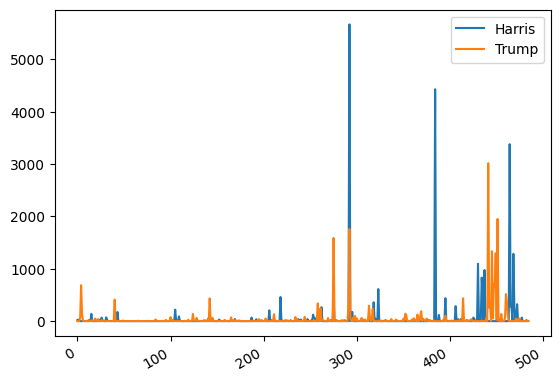

In [51]:
fig, ax = plt.subplots()

line_yes, = ax.plot(cross_category['Harris, Kamala'].to_list(), label='Harris')
line_no, = ax.plot(cross_category['Trump, Donald J.'].to_list(), label='Trump')

fig.autofmt_xdate()

ax.legend(handles = [line_yes, line_no])
plt.show()

Conduct a chi-squared test to see if Harris and Trump have similar spending patterns state by state, as in do they both focus on the same states? 

In [52]:
harristrump_spending_df = spending_df[(spending_df['cand_nm'] == 'Harris, Kamala') | (spending_df['cand_nm'] == 'Trump, Donald J.')]
cross_state = pd.crosstab(harristrump_spending_df['recipient_st'], harristrump_spending_df['cand_nm'])
scipy.stats.chi2_contingency(cross_state).pvalue

0.0

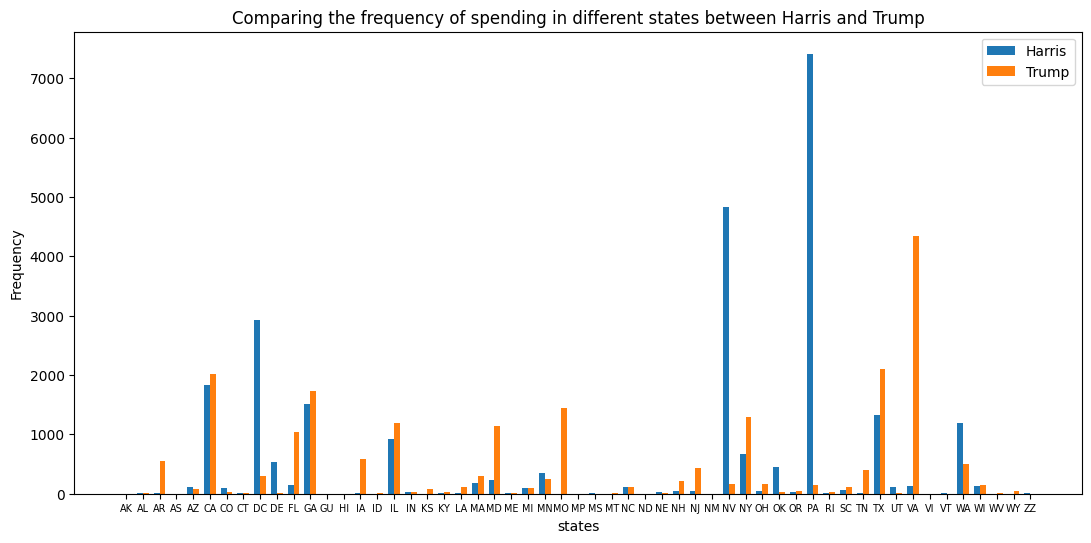

In [53]:
fig, ax = plt.subplots(figsize=(13,6))

states = list(cross_state.index)
bar_width = 0.35


observed_bars = ax.bar(np.arange(len(states)), cross_state['Harris, Kamala'], bar_width, label='Harris')
expected_bars = ax.bar(np.arange(len(states)) + bar_width, cross_state['Trump, Donald J.'], bar_width, label='Trump')

# Add labels and annotations
ax.set_xticks(np.arange(len(states)) + bar_width / 2, states, size='x-small')
ax.set_xlabel('states')
ax.set_ylabel('Frequency')
ax.set_title('Comparing the frequency of spending in different states between Harris and Trump')
ax.set
ax.legend()
plt.show()

Analysis: Our Chi-square test results indicate that Trump and Harris have largely similar spending habits in most types of financial transactions, 
but that there are certain areas where the Harris campaign engages in far more frequent spending than the Trump campaign and vice versa.
The Harris campaign also appears to outspend the Trump campaign in areas with frequent financial transactions, since there are a few instances
of Trump's campaign having two to three thousand transactions in areas where Harris' campaign had almost zero while there are a few more instances
of Harris' campaign having three to five thousand transactions or more in areas where Trump's campaign had at most only a thousand transactions.
Without further data, this information could support several possible conclusions, including that Harris' campaign is generally far outspending
Trump's or that Trump's campaign may be engaging in fewer, more costly transactions while Harris' transaction counts are heavily inflated because
individual transaction amounts are quite small. Moreover, we see from the graph comparing number of candidate transactions by state, we can see
that as we might expect the candidates are heavily focusing most of their transactions and spending in specific states: Harris appears to be
focusing many of her campaign transactions on Delaware and especially Pennsylvania, given that Biden claims a sort of home field advantage within
both states and in particular Pennsylvania is a swing state that may make or break either candidates' presidential bids. Likewise, Trump's number of
transactions appears to be highest in more purple states like Ohio and even Texas. Interestingly, Trump's campaign appears to have the most financial
transactions in Virginia and many in Maryland, both of which are solidly blue states. This may be because of the senate races in both states, or perhaps
peculiar campaign funding laws in both states, or even because of a belief within the Trump campaign team that they might be able to flip a state like
Virginia given Republican Governor Glenn Youngkin's recent election and tremendous popularity within the state.

# TEST 2: Correlation

In [54]:
# https://www.fec.gov/data/candidates/president/presidential-map/ 
# spending - allcandidates 
types = {
    "cmte_id" : str,
    "cand_id" : str,
    "recipient_nm" : str,
    "disb_amt" : float,
    "disb_dt" : str,
    "recipient_city" : str,
    "recipient_st" : str,
    "recipient_zip" : str,
    "disb_desc" : str,
    "memo_cd" : str,
    "memo_text" : str,
    "form_tp" : str,
    "file_num" : str,
    "tran_id" : str,
    "election_tp" : str
}

spending_df = pd.read_csv("spending_data_2024.csv", index_col=False, dtype=types)
spending_df["disb_dt"] = pd.to_datetime(spending_df["disb_dt"], format='%d-%b-%y')
# spending_df

In [55]:
cand_info = pd.read_csv("weball24.txt", delimiter='|')
# cand_info

In [56]:
poll_data = pd.read_csv("presidential_general_averages.csv")
poll_data["date"] = pd.to_datetime(poll_data["date"])
# poll_data

Correlation Between Trump's and Harris's Total Spending and National Polling Average

In [57]:
# Add column to poll_data with state abbreviations 
states_abbr = spending_df.recipient_st.unique()
# states_abbr

In [58]:
state_abbrvs = pd.read_csv("states.csv", index_col = 0)
# state_abbrvs.head()

In [59]:
states = poll_data.state.unique()
# [s for s in states if s not in state_abbrvs["Abbreviation"]]

In [60]:
abbrvs = list()

for s in poll_data["state"]:
    if (s == 'ME-1') | (s == 'ME-2') | (s == 'Maine Cd 2'):
        abbrvs.append("ME")
    elif s == "NE-2":
        abbrvs.append("NE")
    elif s == "Nebraska Cd 2":
        abbrvs.append("NE")
    elif s == "National":
        abbrvs.append("National")
    else:
        abbrvs.append(state_abbrvs["Abbreviation"][s])
    
poll_data["state_abbrv"] = abbrvs
# poll_data

In [61]:
harris_spending_23_24 = spending_df[spending_df["cand_nm"] == "Harris, Kamala"]
hs_spending_per_day = harris_spending_23_24.groupby("disb_dt")["disb_amt"].sum()
# hs_spending_per_day

In [62]:
harris_spending_23_24 = spending_df[spending_df["cand_nm"] == "Harris, Kamala"]
hs_spending_per_day_per_state = harris_spending_23_24.groupby(["recipient_st","disb_dt"])["disb_amt"].sum()
hs_spending_per_day_per_state_df = pd.DataFrame(index = hs_spending_per_day_per_state.index.get_level_values("disb_dt").unique(), columns = hs_spending_per_day_per_state.index.get_level_values("recipient_st").unique())

for st in hs_spending_per_day_per_state_df.columns:
    hs_spending_per_day_per_state_df[st] = hs_spending_per_day_per_state[st]

hs_spending_per_day_per_state_df =hs_spending_per_day_per_state_df.fillna(0)
# hs_spending_per_day_per_state_df 

In [63]:
trump_spending_23_24 = spending_df[(spending_df["cand_nm"] == "Trump, Donald J.")]
tp_spending_per_day = trump_spending_23_24.groupby("disb_dt")["disb_amt"].sum()
# tp_spending_per_day

In [64]:
trump_spending_23_24 = spending_df[spending_df["cand_nm"] == "Trump, Donald J."]
tp_spending_per_day_per_state = trump_spending_23_24.groupby(["recipient_st","disb_dt"])["disb_amt"].sum()
tp_spending_per_day_per_state_df = pd.DataFrame(index = tp_spending_per_day_per_state.index.get_level_values("disb_dt").unique(), columns = tp_spending_per_day_per_state.index.get_level_values("recipient_st").unique())

for st in tp_spending_per_day_per_state_df.columns:
    tp_spending_per_day_per_state_df[st] = tp_spending_per_day_per_state[st]
tp_spending_per_day_per_state_df = tp_spending_per_day_per_state_df.fillna(0)    
# tp_spending_per_day_per_state_df.head() 

In [65]:
harris_nat_polls = poll_data[(poll_data["candidate"] == "Harris") & (poll_data["state"] == "National")]
# harris_nat_polls

In [66]:
trump_nat_polls = poll_data[(poll_data["candidate"] == "Trump") & (poll_data["state"] == "National")]
# trump_nat_polls.head()

In [67]:
trump_spending_to_polls = trump_nat_polls[["date", "pct_estimate"]].set_index("date")
trump_spending_to_polls = trump_spending_to_polls[trump_spending_to_polls.index.isin(tp_spending_per_day.index)]
trump_spending_to_polls["total_spending"] = tp_spending_per_day
# trump_spending_to_polls

In [68]:
harris_spending_to_polls = harris_nat_polls[["date", "pct_estimate"]].set_index("date")
harris_spending_to_polls = harris_spending_to_polls[harris_spending_to_polls.index.isin(hs_spending_per_day.index)]
harris_spending_to_polls["total_spending"] = hs_spending_per_day
# harris_spending_to_polls.head()

In [69]:
harris_corr_mtx = harris_spending_to_polls.corr(method="spearman")
harris_corr_mtx

,pct_estimate,total_spending
pct_estimate,1.000000,0.126721
total_spending,0.126721,1.000000


In [70]:
trump_corr_mtx = trump_spending_to_polls.corr(method="spearman")
trump_corr_mtx

,pct_estimate,total_spending
pct_estimate,1.000000,-0.038858
total_spending,-0.038858,1.000000


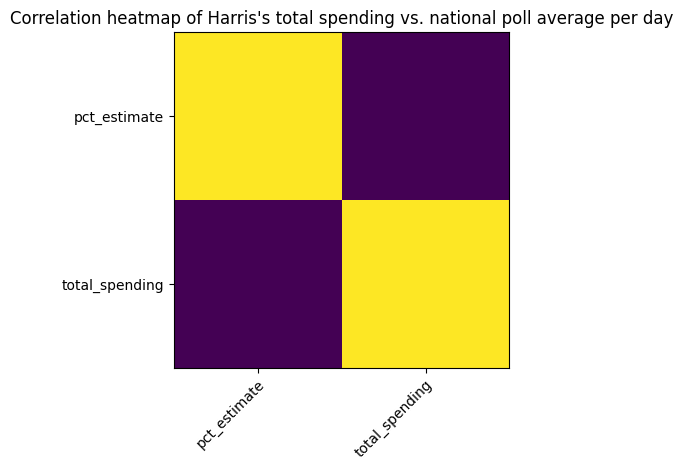

In [71]:
fig, ax = plt.subplots()
im = ax.imshow(harris_corr_mtx)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(2), labels=harris_corr_mtx.index)
ax.set_yticks(range(2), labels=harris_corr_mtx.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Correlation heatmap of Harris's total spending vs. national poll average per day")
fig.tight_layout()
plt.show()

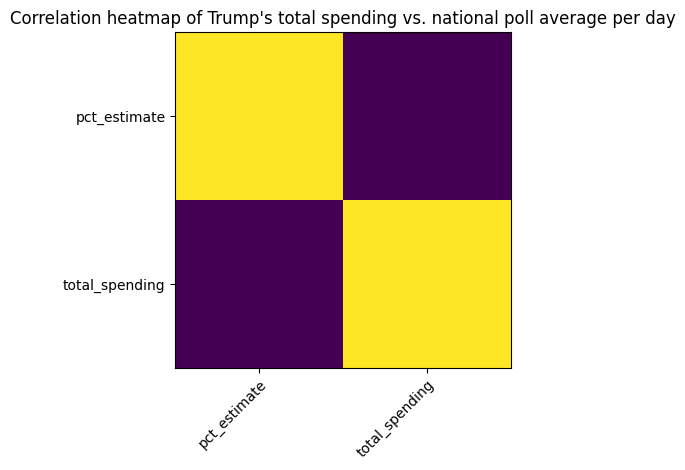

In [72]:
fig, ax = plt.subplots()
im = ax.imshow(trump_corr_mtx)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(2), labels=trump_corr_mtx.index)
ax.set_yticks(range(2), labels=trump_corr_mtx.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Correlation heatmap of Trump's total spending vs. national poll average per day")
fig.tight_layout()
plt.show()

In [73]:
harris_corr_mtx = hs_spending_per_day_per_state_df.corr(method="spearman") 

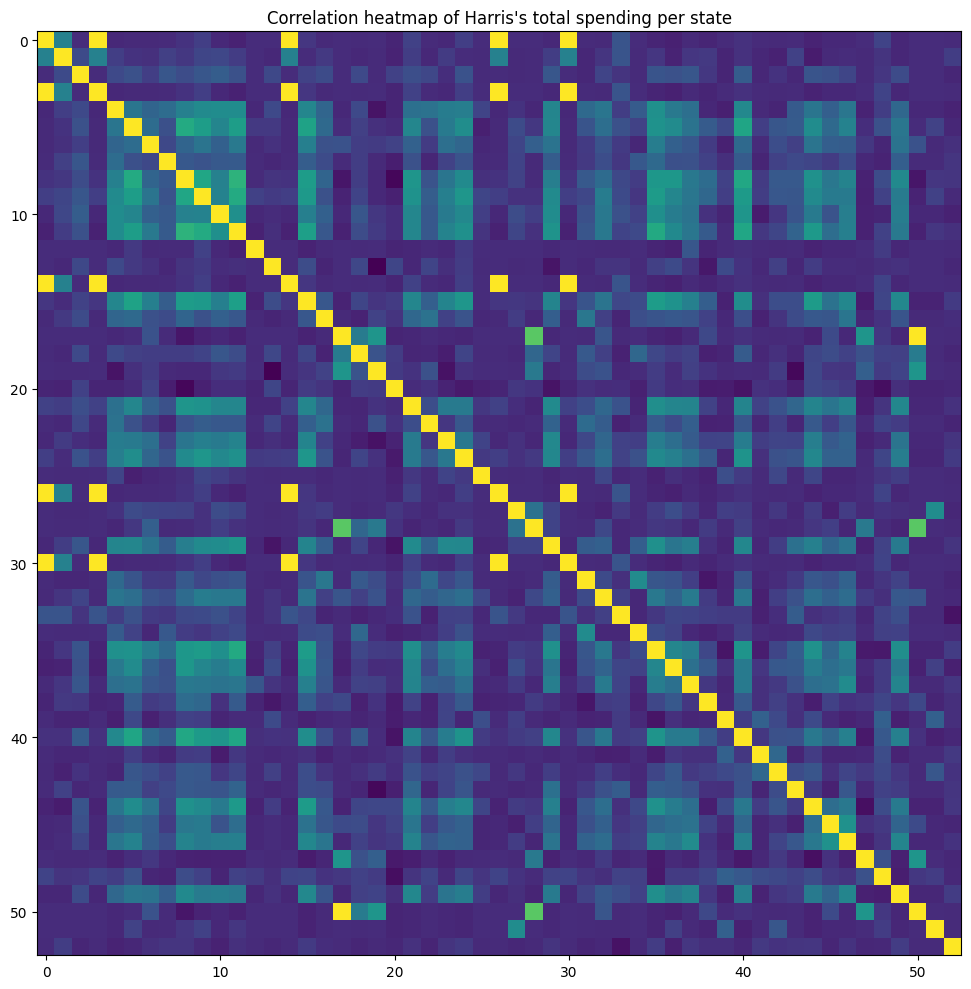

<Figure size 100000x100000 with 0 Axes>

In [74]:
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(harris_corr_mtx)

plt.figure(figsize=(1000,1000))

ax.set_title("Correlation heatmap of Harris's total spending per state")
fig.tight_layout()
plt.show()

In [75]:
trump_corr_mtx = tp_spending_per_day_per_state_df.corr(method="spearman")

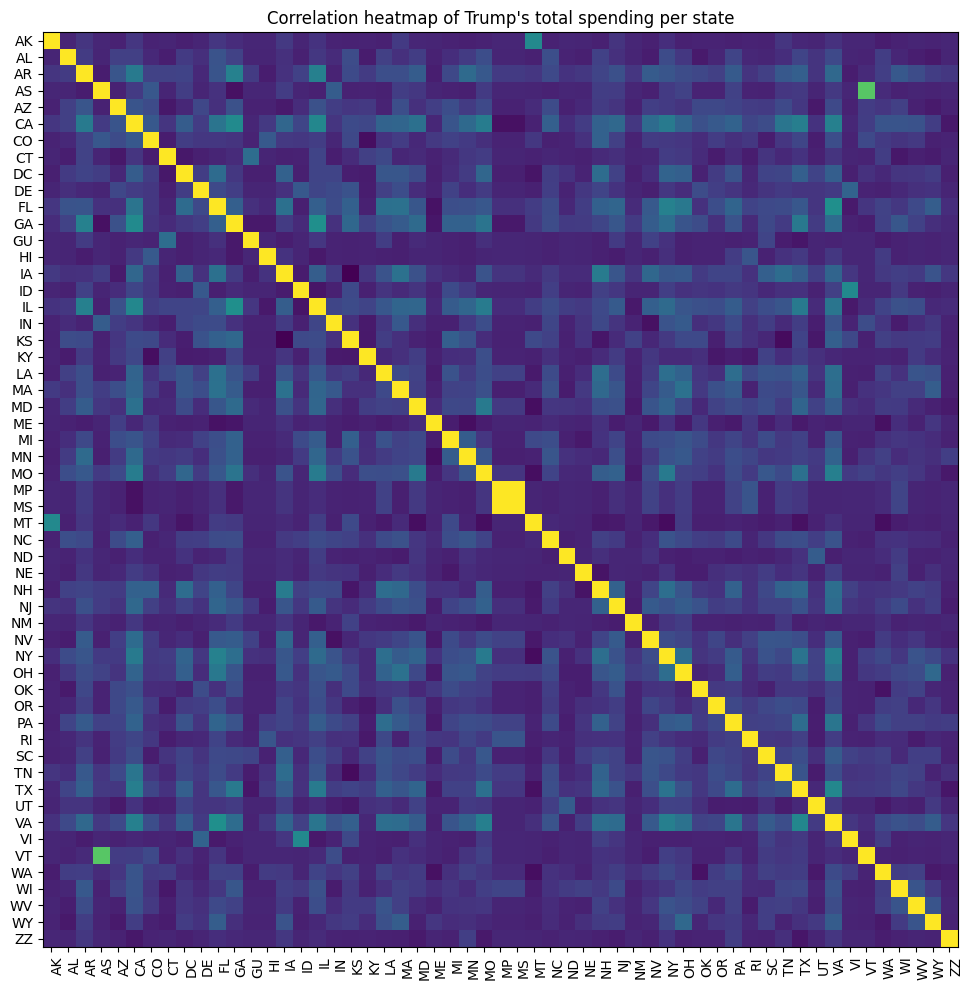

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(trump_corr_mtx)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(55), labels=trump_corr_mtx.index, fontsize=10)
ax.set_yticks(range(55), labels=trump_corr_mtx.columns, fontsize=10)

#Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

ax.set_title("Correlation heatmap of Trump's total spending per state")
fig.tight_layout()
plt.show()

Analysis:

When discovering the correlation between estimated poll and total spending, Spearman correlation is applied due to the unknown nature of the relationship.
Harris' stats present a weak positive correlation between her spending and her estimated poll.
This implies that the increased spending have little impact on her polling performance.
Trump's stats present a weak negative correlation between his spending and his estimated poll. 
This implies that the increased spending wouldn't likely to impact on his polling performance or have slight negative impact.
Harris have benefits little from the spending, while trump didn't. This may impies that Trump have more solid brand recognition than Harris.
Volters volt Trump dispite his spending. While Harris may need to spend more to gain public recognition. 
The spending of both candidates presents low impact on the result.
This may implies that officially count spending is not the primary factor that influence the poll.
External influences like support from public celebrities (e.g. Elon Musk/Taylor Swift) or donation to Pro-Trump, Pro-Harris Committee impact more. 
Another possible reason is that some states are Pro-Democrates or Pro-Republics by default. Both candidates may spend more at states that oppose with their party and receive relatively weak response.

For the correlation between spending of each states, The presence of more green clusters on Harris’s heatmap compared to Trump’s indicates that Harris's state-level spending patterns are more correlated across multiple states.
This implies that Harris have more consistent spending strategy across states. Her spending may be more universal across multiple states.
On the opposite, Trump's spending may be more targeted, focusing on specific states independently with different priorities.
Trump may allocate resources opportunistically, depending on shifting poll numbers or last-minute campaign needs, leading to less consistency in spending patterns.

# Test 3: 1 Tailed Wilcoxon Test

In [77]:
polling_df = pd.read_csv('presidential_general_averages.csv')
polling_df['date'] = pd.to_datetime(polling_df['date']).dt.date

harris_df = polling_df[(polling_df['candidate'].str.contains('Harris')) & (polling_df['date'] >= datetime.date(2024, 7, 24)) & (polling_df['state'] == 'National')][['date', 'pct_estimate']]

trump_df = polling_df[(polling_df['candidate'].str.contains('Trump')) & (polling_df['date'] >= datetime.date(2024, 7, 24)) & (polling_df['state'] == 'National')][['date', 'pct_estimate']]

wilcoxon(harris_df['pct_estimate'], trump_df['pct_estimate'], alternative='greater')

WilcoxonResult(statistic=5565.0, pvalue=2.917717369616875e-19)

In [78]:
polling_df = pd.read_csv('presidential_general_averages.csv')
polling_df['date'] = pd.to_datetime(polling_df['date']).dt.date

Analysis: 
The 'date' column is stored as a string and must be converted to a datetime value before use. The pct_trend_adjusted and pct_estimate columns are mutually exclusive, all rows which have a number in the pct_trend_adjusted column have NaN in the pct_estimate column, and vice versa. All of the most recent polls have pct_estimate and not pct_trend_adjusted. Some of the entries contain the full names of the candidates, e.g. 'Joseph R. Biden', while others only contain the last name 'Biden'. The polls include both state specific poll numbers and national averages. 

In the code below, a one-tailed Wilcoxon Signed-Rank test is performed where the pairs consist of the national poll averages for Harris and Trump on the same date. This test was chosen because the polling numbers for Harris and Trump are related, especially on the same date, and polling averages cannot safely be assumed to be normal over time.

$H_0 = \mu_{\text{Harris}} <= \mu_{\text{Trump}}$\
$H_A = \mu_{\text{Harris}} > \mu_{\text{Trump}}$

$\alpha = 0.05$

Wilcoxon Test Results:\
test statistic: 3828.0\
p-value (right-tailed) = 2.730e-16

Since p-value < $\alpha$, we reject the null hypothesis. Given the incredibly small p-value, it is incredibly unlikely that Harris's national polling numbers are less than or equal to Trump's. Harris's poll numbers are greater than Trump's in a statistically significant manner.

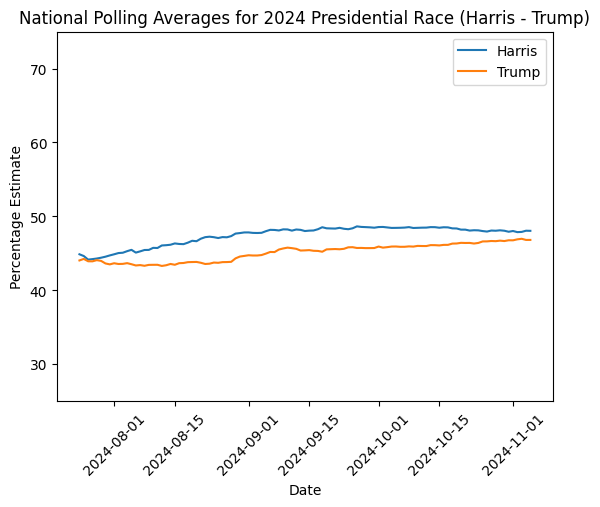

In [79]:
sns.lineplot(data=harris_df, x='date', y='pct_estimate', label='Harris')
sns.lineplot(data=trump_df, x='date', y='pct_estimate', label='Trump')

plt.title('National Polling Averages for 2024 Presidential Race (Harris - Trump)')
plt.xlabel('Date')
plt.ylabel('Percentage Estimate')

plt.xticks(rotation=45)
plt.ylim(bottom=25, top=75)
plt.show()

# **SECTION 5: Primary Analysis**

Need a constant that will help convert the predicted states into actual electoral vote counts.

In [80]:
electoral_votes = {
    "Alabama": 9,
    "Alaska": 3,
    "Arizona": 11,
    "Arkansas": 6,
    "California": 54,
    "Colorado": 10,
    "Connecticut": 7,
    "Delaware": 3,
    "District of Columbia": 3,
    "Florida": 30,
    "Georgia": 16,
    "Hawaii": 4,
    "Idaho": 4,
    "Illinois": 19,
    "Indiana": 11,
    "Iowa": 6,
    "Kansas": 6,
    "Kentucky": 8,
    "Louisiana": 8,
    "Maine": 2,
    "ME-1": 1,
    "ME-2": 1,
    "Maryland": 10,
    "Massachusetts": 11,
    "Michigan": 15,
    "Minnesota": 10,
    "Mississippi": 6,
    "Missouri": 10,
    "Montana": 4,
    "Nebraska": 2,
    "NE-1": 1,
    "NE-2": 1,
    "NE-3": 1,
    "Nevada": 6,
    "New Hampshire": 4,
    "New Jersey": 14,
    "New Mexico": 5,
    "New York": 28,
    "North Carolina": 16,
    "North Dakota": 3,
    "Ohio": 17,
    "Oklahoma": 7,
    "Oregon": 8,
    "Pennsylvania": 19,
    "Rhode Island": 4,
    "South Carolina": 9,
    "South Dakota": 3,
    "Tennessee": 11,
    "Texas": 40,
    "Utah": 6,
    "Vermont": 3,
    "Virginia": 13,
    "Washington": 12,
    "West Virginia": 4,
    "Wisconsin": 10,
    "Wyoming": 3
}

From our data exploration, we have found that polling and spending data do not have a straightforward relationship with the results of an election. Higher polls or higher spending often does not correlate with winning the state. There is clearly a very complicated relationship between these features and which party wins the state. 

Due to this complex relationship between polling and spending data and election results, we decided to use a Multi-layer Perceptron. Being a neural network, it is better suited to handle more complex relationships. 

Furthermore, because we want to avoid label encoding in order to avoid introducing unintended ordinal relationships for the states, we will use One-Hot Encoding. Since there are 56 state/districts, this encoding will greatly increase the dimensionality of our dataset. Neural networks are also better suited to handling higher dimensional data.

Note: Because our dataset is relatively small, we will use the lbfgs solver for the Multi-layer Perceptron Classifier as it tends to perform better on smaller datasets.

To learn more about the inner workings of Multi-layer Perceptrons, go to: https://www.datacamp.com/tutorial/multilayer-perceptrons-in-machine-learning

1. We will need to convert some categorical variables into encodings and normalize the numeric columns.

In [81]:
# Specify the column to apply OneHotEncoder
categorical_columns = ['state']

# Specify the columns for StandardScaler (assuming X_train is a DataFrame)
numerical_columns = [col for col in X_train.columns if col not in categorical_columns]

# Set up a preprocessor to help convert categorial columns into One Hot Encodings, and normalize the other values
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('scaler', StandardScaler(), numerical_columns)
    ]
)

2. Now, we will need to create a MLPClassifier

In [82]:
classifier = MLPClassifier(max_iter=500, solver='lbfgs')

3. We will add each classifier to a pipline with the preprocessor and run it on the data. 

In [83]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', classifier)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

final_results = X_test.copy()
final_results['actual'] = y_test
final_results['predict'] = y_pred
final_results[~(final_results['actual'] == final_results['predict'])]

final_results['electoral_votes'] = final_results['state'].map(lambda e: electoral_votes[e])

# Get the total electoral votes for each party
final_results[['predict', 'electoral_votes']].groupby('predict').sum()

,electoral_votes
predict,
DEMOCRAT,225
REPUBLICAN,310


Note: Because DC was lacking any polling for the 2024 cycle, it was not predicted, so the predicted electoral vote totals do not add to the correct 538.

Compare the predicted results to the actual results below:

DEMOCRAT: 226

REPUBLICAN: 312

Real results excluding DC:

DEMOCRAT: 223
REPUBLICAN: 312